In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import warnings
warnings.filterwarnings('ignore')

# Настройки для визуализации
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")
%matplotlib inline

In [123]:
# Загрузка агрегированных данных из предоставленного документа
data = pd.read_csv('crime_forecast.csv')  # Предполагается, что данные сохранены в CSV
print(f"Данные загружены. Размер датасета: {data.shape}")
print("\nПервые 5 строк:")
display(data.head())

Данные загружены. Размер датасета: (126, 10)

Первые 5 строк:


,AREA NAME,Year,Month,crime_count,date,prev_month_crimes,prev_2_months_avg,prev_3_months_avg,month_sin,month_cos
0,77th Street,2024,1,202.03,2024-01-01,283.00,262.500,260.500000,0.500000,8.660254e-01
1,77th Street,2024,2,209.94,2024-02-01,202.03,242.515,249.176667,0.866025,5.000000e-01
2,77th Street,2024,3,191.07,2024-03-01,209.94,205.985,218.161667,1.000000,6.123234e-17
3,77th Street,2024,4,202.05,2024-04-01,191.07,200.505,202.331667,0.866025,-5.000000e-01
4,77th Street,2024,5,185.76,2024-05-01,202.05,196.560,197.875000,0.500000,-8.660254e-01


In [127]:
# Пример агрегации из исходного датасета (если нужно)
df = pd.read_csv('data/data2.csv')  # Замените на ваш путь к файлу
invalid_dates = df[~df['DATE OCC'].str.match(r'\d{2}/\d{2}/\d{4} \d{1,2}:\d{2}:\d{2} [APMapm]{2}', na=False)]
print(invalid_dates['DATE OCC'])
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
df = df.dropna(subset=['DATE OCC'])  # Удалить строки, где дата не распарсилась
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], format='%m/%d/%Y %I:%M:%S %p')
df['Year'] = df['DATE OCC'].dt.year
df['Month'] = df['DATE OCC'].dt.month
crime_aggregated = df.groupby(['AREA NAME', 'Year', 'Month']).size().reset_index(name='crime_count')
crime_aggregated['date'] = pd.to_datetime(crime_aggregated[['Year', 'Month']].assign(day=1))
data = crime_aggregated.sort_values(['AREA NAME', 'date'])




698667    09/18/2023 12:00:0{
698668                    NaN
698669                    NaN
698670                    NaN
698671                    NaN
Name: DATE OCC, dtype: object


In [128]:
# Создание лаговых признаков
data['prev_month_crimes'] = data.groupby('AREA NAME')['crime_count'].shift(1)
data['prev_2_months_avg'] = data.groupby('AREA NAME')['crime_count'].shift(1).rolling(window=2, min_periods=1).mean()
data['prev_3_months_avg'] = data.groupby('AREA NAME')['crime_count'].shift(1).rolling(window=3, min_periods=1).mean()

# Сезонные признаки
data['month_sin'] = np.sin(2 * np.pi * data['Month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['Month'] / 12)

# Заполнение пропусков
data = data.fillna(0)

print("\nДанные с новыми признаками:")
display(data.head())


Данные с новыми признаками:


,AREA NAME,Year,Month,crime_count,date,prev_month_crimes,prev_2_months_avg,prev_3_months_avg,month_sin,month_cos
0,77th Street,2020,1,1304,2020-01-01,0.0,0.0,0.000000,0.500000,8.660254e-01
1,77th Street,2020,2,1100,2020-02-01,1304.0,1304.0,1304.000000,0.866025,5.000000e-01
2,77th Street,2020,3,1012,2020-03-01,1100.0,1202.0,1202.000000,1.000000,6.123234e-17
3,77th Street,2020,4,1063,2020-04-01,1012.0,1056.0,1138.666667,0.866025,-5.000000e-01
4,77th Street,2020,5,1074,2020-05-01,1063.0,1037.5,1058.333333,0.500000,-8.660254e-01


In [129]:
# Разделение на категории
quantiles = data['crime_count'].quantile([0.33, 0.66])
data['crime_level'] = pd.cut(data['crime_count'],
                             bins=[-np.inf, quantiles[0.33], quantiles[0.66], np.inf],
                             labels=['Low', 'Medium', 'High'])

print("\nРаспределение классов:")
print(data['crime_level'].value_counts())


Распределение классов:
crime_level
High      341
Medium    334
Low       333
Name: count, dtype: int64


In [130]:
features = ['Year', 'Month', 'month_sin', 'month_cos', 'prev_month_crimes', 
            'prev_2_months_avg', 'prev_3_months_avg']
X = data[features + ['AREA NAME']]
y = data['crime_level']

# Разделение данных
train_idx = int(len(data) * 0.7)
val_idx = int(len(data) * 0.85)

X_train = X.iloc[:train_idx]
y_train = y.iloc[:train_idx]
X_val = X.iloc[train_idx:val_idx]
y_val = y.iloc[train_idx:val_idx]
X_test = X.iloc[val_idx:]
y_test = y.iloc[val_idx:]

print(f"Размеры выборок: Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Размеры выборок: Train: (705, 8), Val: (151, 8), Test: (152, 8)


In [131]:
# Определение числовых и категориальных колонок
numeric_features = features
categorical_features = ['AREA NAME']

# Создание препроцессора
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

# Создание пайплайна с RandomForestClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Обучение модели
pipeline.fit(X_train, y_train)

print("Модель обучена!")

Модель обучена!



Результаты на валидационной выборке:
              precision    recall  f1-score   support

        High       0.93      0.84      0.88        45
         Low       0.96      0.96      0.96        47
      Medium       0.86      0.92      0.89        59

    accuracy                           0.91       151
   macro avg       0.91      0.91      0.91       151
weighted avg       0.91      0.91      0.91       151



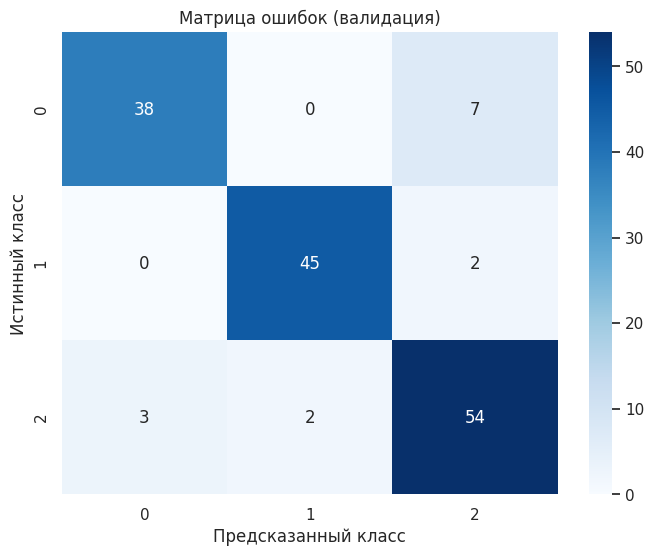


Результаты на тестовой выборке:
              precision    recall  f1-score   support

        High       0.83      0.71      0.76        41
         Low       0.98      0.88      0.92        56
      Medium       0.72      0.87      0.79        55

    accuracy                           0.83       152
   macro avg       0.84      0.82      0.82       152
weighted avg       0.84      0.83      0.83       152



In [132]:
# Предсказания на валидационной выборке
y_val_pred = pipeline.predict(X_val)
print("\nРезультаты на валидационной выборке:")
print(classification_report(y_val, y_val_pred))

# Визуализация матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок (валидация)')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

# Предсказания на тестовой выборке
y_test_pred = pipeline.predict(X_test)
print("\nРезультаты на тестовой выборке:")
print(classification_report(y_test, y_test_pred))

In [133]:
# Сохранение модели
joblib.dump(pipeline, 'crime_level_classifier.pkl')
print("Модель сохранена в 'crime_level_classifier.pkl'")

Модель сохранена в 'crime_level_classifier.pkl'


In [134]:
def predict_crime_level(new_data, model_path='crime_level_classifier.pkl'):
    """
    Предсказывает уровень криминогенности для новых данных.
    
    Args:
        new_data (pd.DataFrame): Данные с колонками ['AREA NAME', 'Year', 'Month', 
                                 'prev_month_crimes', 'prev_2_months_avg', 'prev_3_months_avg']
        model_path (str): Путь к сохраненной модели
    
    Returns:
        np.array: Предсказанные классы ('Low', 'Medium', 'High')
    """
    # Загрузка модели
    model = joblib.load(model_path)
    
    # Добавление сезонных признаков
    new_data['month_sin'] = np.sin(2 * np.pi * new_data['Month'] / 12)
    new_data['month_cos'] = np.cos(2 * np.pi * new_data['Month'] / 12)
    
    # Проверка наличия всех необходимых колонок
    required_cols = features + ['AREA NAME']
    if not all(col in new_data.columns for col in required_cols):
        raise ValueError(f"В данных отсутствуют необходимые колонки: {required_cols}")
    
    # Предсказание
    predictions = model.predict(new_data[required_cols])
    return predictions

# Пример использования
new_data_example = pd.DataFrame({
    'AREA NAME': ['Central', 'Hollywood'],
    'Year': [2024, 2024],
    'Month': [7, 7],
    'prev_month_crimes': [287.43, 194.15],
    'prev_2_months_avg': [284.925, 202.51],
    'prev_3_months_avg': [284.201, 202.705]
})

predictions = predict_crime_level(new_data_example)
print("\nПример предсказаний:")
for area, pred in zip(new_data_example['AREA NAME'], predictions):
    print(f"{area}: {pred}")


Пример предсказаний:
Central: Low
Hollywood: Low


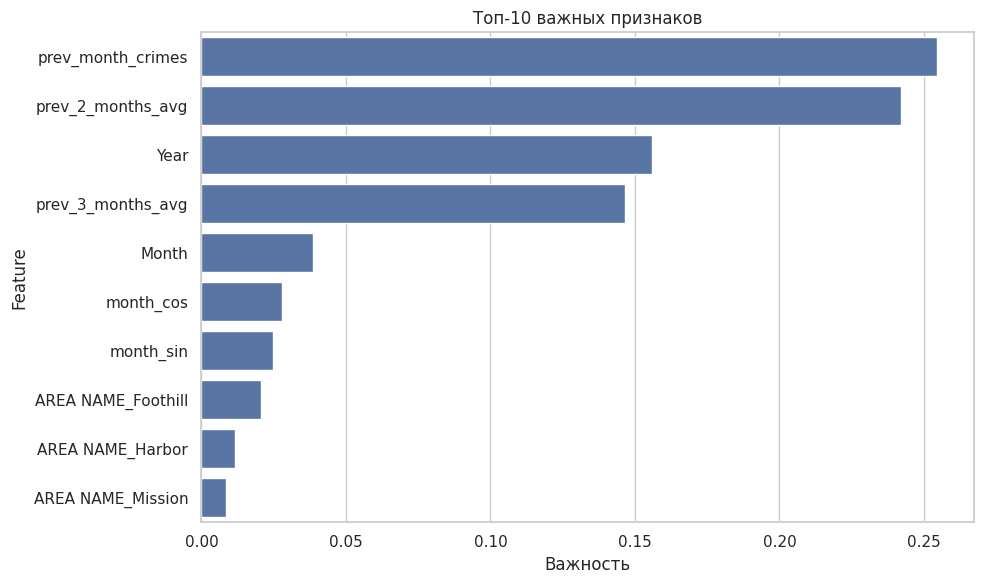

In [135]:
# Извлечение важности признаков
feature_importances = pipeline.named_steps['classifier'].feature_importances_
feature_names = (numeric_features + 
                 pipeline.named_steps['preprocessor']
                 .named_transformers_['cat']
                 .get_feature_names_out(categorical_features).tolist())

# Создание DataFrame с важностью
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values('Importance', ascending=False).head(10)

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Топ-10 важных признаков')
plt.xlabel('Важность')
plt.tight_layout()
plt.show()

Точность (Accuracy): 0.83

Подробный отчет по метрикам:
              precision    recall  f1-score   support

        High       0.83      0.71      0.76        41
         Low       0.98      0.88      0.92        56
      Medium       0.72      0.87      0.79        55

    accuracy                           0.83       152
   macro avg       0.84      0.82      0.82       152
weighted avg       0.84      0.83      0.83       152



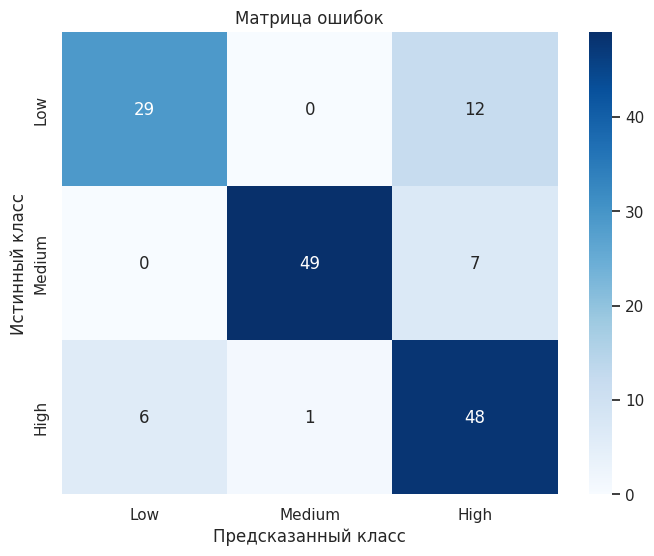

Weighted F1-score: 0.83
Macro F1-score: 0.82


In [136]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

y_test_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
print(f"Точность (Accuracy): {accuracy:.2f}")

print("\nПодробный отчет по метрикам:")
print(classification_report(y_test, y_test_pred))

conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.title('Матрица ошибок')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.show()

weighted_f1 = f1_score(y_test, y_test_pred, average='weighted')
macro_f1 = f1_score(y_test, y_test_pred, average='macro')
print(f"Weighted F1-score: {weighted_f1:.2f}")
print(f"Macro F1-score: {macro_f1:.2f}")